## Preprocessing

This analysis starts with a file preprocessed using trjconv and the following commands
```
echo 'Protein' 'non-Water' | gmx trjconv -f step3b_production.xtc -s step3b_production.tpr -skip 100 -b 700000 -e 1500000 -o parse_traj_700-1500ns_nowater.xtc -pbc whole -ur compact -center

echo 'Protein' 'non-Water' | gmx trjconv -f step3b_production.xtc -s step3b_production.tpr -skip 100 -b 700000 -e 1500000 -o parse_traj_700-1500ns_nowater.gro -pbc whole -ur compact -center -dump 0
```

## Analysis

In [1]:
from MDAnalysis import *
from membrane_curvature.base import MembraneCurvature
from MDAnalysis.transformations.wrap import wrap, unwrap
from MDAnalysis.analysis.leaflet import LeafletFinder
import numpy as np

universes = [(('../sv_membrane/c2a_only/0_deg/parse_traj_700-1500ns_nowater.gro', '../sv_membrane/c2a_only/0_deg/parse_traj_700-1500ns_nowater.xtc'), 'SV', '0deg'),
             (('../sv_membrane/c2a_only/30_deg/parse_traj_700-1500ns_nowater.gro', '../sv_membrane/c2a_only/30_deg/parse_traj_700-1500ns_nowater.xtc'), 'SV', '30deg'),
             (('../sv_membrane/c2a_only/60_deg/parse_traj_700-1500ns_nowater.gro', '../sv_membrane/c2a_only/60_deg/parse_traj_700-1500ns_nowater.xtc'), 'SV', '60deg'),
             #
             (('../sv_membrane/c2a_ca/0_deg/parse_traj_700-1500ns_nowater.gro', '../sv_membrane/c2a_ca/0_deg/parse_traj_700-1500ns_nowater.xtc'), 'SV Ca', '0deg'),
             (('../sv_membrane/c2a_ca/30_deg/parse_traj_700-1500ns_nowater.gro', '../sv_membrane/c2a_ca/30_deg/parse_traj_700-1500ns_nowater.xtc'), 'SV Ca', '30deg'),
             (('../sv_membrane/c2a_ca/60_deg/parse_traj_700-1500ns_nowater.gro', '../sv_membrane/c2a_ca/60_deg/parse_traj_700-1500ns_nowater.xtc'), 'SV Ca', '60deg'),
             #
             (('../pm_membrane/c2a_only/0_deg/parse_traj_700-1500ns_nowater.gro', '../pm_membrane/c2a_only/0_deg/parse_traj_700-1500ns_nowater.xtc'), 'PM', '0deg'),
             (('../pm_membrane/c2a_only/30_deg/parse_traj_700-1500ns_nowater.gro', '../pm_membrane/c2a_only/30_deg/parse_traj_700-1500ns_nowater.xtc'), 'PM', '30deg'),
             (('../pm_membrane/c2a_only/60_deg/parse_traj_700-1500ns_nowater.gro', '../pm_membrane/c2a_only/60_deg/parse_traj_700-1500ns_nowater.xtc'), 'PM', '60deg'),
             #
             (('../pm_membrane/c2a_ca/0_deg/parse_traj_700-1500ns_nowater.gro', '../pm_membrane/c2a_ca/0_deg/parse_traj_700-1500ns_nowater.xtc'), 'PM Ca', '0deg'),
             (('../pm_membrane/c2a_ca/30_deg/parse_traj_700-1500ns_nowater.gro', '../pm_membrane/c2a_ca/30_deg/parse_traj_700-1500ns_nowater.xtc'), 'PM Ca', '30deg'),
             (('../pm_membrane/c2a_ca/60_deg/parse_traj_700-1500ns_nowater.gro', '../pm_membrane/c2a_ca/60_deg/parse_traj_700-1500ns_nowater.xtc'), 'PM Ca', '60deg'),
             
            ]


MDAnalysis  : INFO     MDAnalysis 2.5.0 STARTED logging to 'MDAnalysis.log'
MDAnalysis  : INFO     MDAnalysis 2.5.0 STARTED logging to 'MDAnalysis.log'
MDAnalysis  : INFO     MDAnalysis 2.5.0 STARTED logging to 'MDAnalysis.log'


In [2]:
def center_protein_xy_and_translate_membrane_z(ag, prot, leaflet, phosphate_z):
    def wrapped(ts):
        ## center the protein in the box
        protein_center = prot.center_of_mass(pbc=False) # no PBC as preprocessed with trjconv
        dim = ts.triclinic_dimensions
        box_center = np.sum(dim, axis=0) / 2
        # vector connecting the COM and the box center
        trans_vec = box_center - protein_center
        ag.translate(trans_vec)
        
        # find the COM of the membrane
        leaflet_center = leaflet.center_of_mass(pbc=False)
        # translate in xy-direction to center the protein and in z-direction to position the
        # membrane at a defined z-coordinate (z=20)
        trans_z = phosphate_z-leaflet_center[2]
        ag.translate(np.array([0,0,trans_z]))

        # clean up the moved lipids after translation
        ag.wrap(compound='atoms')

        return ts
    return wrapped

In [3]:
### This is a visual control of correct wrapping

import nglview as nv

files = universes[3]

print("Reading files from:\n{}".format(*files[0]))
u = Universe(*files[0], in_memory=True)
        
ag = u.atoms
prot = u.select_atoms("protein")
pro39 = u.select_atoms('resid 39 and protein')
tyr11 = u.select_atoms('resid 11 and protein')

# identify the lipid leaflets
selection = '(resname DOPS or resname POPE or resname POPC or resname POPI2 or resname POGL) and name P'
L = LeafletFinder(u, selection, cutoff=15)
leaflet0 = L.groups(0)
leaflet1 = L.groups(1)

transform = center_protein_xy_and_translate_membrane_z(ag, prot, leaflet1, phosphate_z=20)
u.trajectory.add_transformations(transform)

#ag = u.select_atoms('protein or ((resname DOPS or resname POPE or resname POPC or resname POPI or resname POGL) and (prop y < 10))')
w = nv.show_mdanalysis(ag, default_representation=True)
w.control.spin([0, 1, 0], np.pi)
w.add_unitcell()
w

Reading files from:
../sv_membrane/c2a_ca/0_deg/parse_traj_700-1500ns_nowater.gro


/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/core/groups.py:445: DeprecationWarning: The 'pbc' kwarg has been deprecated and will be removed in version 3.0., please use 'wrap' instead
  warnings.warn("The 'pbc' kwarg has been deprecated and will be "


NGLWidget(max_frame=800)

In [4]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the (direction sensitive) angle between two 2D vectors
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    #return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    return np.arctan2(v2_u[1], v2_u[0]) - np.arctan2(v1_u[1], v1_u[0])

In [5]:
angles_per_universes = []
surf_upper = []
surf_lower = []

mean_upper = []
mean_lower = []

gauss_upper = []
gauss_lower = []


for files in universes:
    
    print("Reading files from:\n{}".format(*files[0]))
    u = Universe(*files[0], in_memory=True)
    
    ## Selections
    ag = u.atoms
    # we need the protein for translation and the residues for
    # calculation of average orientation in xy plane
    prot = u.select_atoms("protein")
    pro39 = u.select_atoms('resid 39 and protein')
    tyr11 = u.select_atoms('resid 11 and protein')

    # we need the lipid leaflet phosphates for curvature
    # calculation
    selection = '(resname DOPS or resname POPE or resname POPC or resname POPI2 or resname POGL) and name P'
    L = LeafletFinder(u, selection, cutoff=15)
    leaflet0 = L.groups(0)
    leaflet1 = L.groups(1)
    
    # center protein in xy and align leaflet0 with z=20
    transform = center_protein_xy_and_translate_membrane_z(ag, prot,
                                                           leaflet1,
                                                           phosphate_z=20)
    u.trajectory.add_transformations(transform)

    # set the dimensions of the analysis grid to the largest dimensions observed for the
    # box during the trajectory
    leaflet0positions_x = np.array([u.dimensions[0] for _ in u.trajectory])
    x_range = (0, leaflet0positions_x.max())

    leaflet0positions_y = np.array([u.dimensions[1] for _ in u.trajectory])
    y_range = (0, leaflet0positions_y.max())
    
    ## Calculation of curvature
    curvature_upper_leaflet = MembraneCurvature(leaflet0,
                                                select='all',
                                                wrap=False, # wrap=False when passing preprocessed trajs!
                                                n_x_bins=8,
                                                n_y_bins=8,
                                                x_range=x_range,
                                                y_range=y_range).run()

    gauss_upper.append(curvature_upper_leaflet.results.average_gaussian)
    mean_upper.append(curvature_upper_leaflet.results.average_mean)
    surf_upper.append(curvature_upper_leaflet.results.average_z_surface)
    
    curvature_lower_leaflet = MembraneCurvature(leaflet1,
                                            select='all',
                                            wrap=False, # wrap=False when passing preprocessed trajs!
                                            n_x_bins=8,
                                            n_y_bins=8,
                                            x_range=x_range,
                                            y_range=y_range).run()

    gauss_lower.append(curvature_lower_leaflet.results.average_gaussian)
    mean_lower.append(curvature_lower_leaflet.results.average_mean)
    surf_lower.append(curvature_lower_leaflet.results.average_z_surface)
    
    ## Calculation or orientation
    # Calculate the main orientation of the protein during trajectory
    angles = []
    for ts in u.trajectory:
        vec = tyr11.center_of_mass() - pro39.center_of_mass()
        # we are only interested in the angle in the xy plane
        vec = vec[0:2]
        angles.append(angle_between(vec, (0,1)))
    
    #print(len(angles))
    angles = [a - 2*np.pi if a > np.pi else a for a in angles]
    angles = [a + 2*np.pi if a < -np.pi else a for a in angles]
    #print(len(angles))
    angles_per_universes.append((np.min(angles), np.max(angles)))

Reading files from:
../sv_membrane/c2a_only/0_deg/parse_traj_700-1500ns_nowater.gro


/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/core/groups.py:445: DeprecationWarning: The 'pbc' kwarg has been deprecated and will be removed in version 3.0., please use 'wrap' instead
  warnings.warn("The 'pbc' kwarg has been deprecated and will be "
/home/aretaon/anaconda3/envs/mdanalysis/lib/python3.11/site-packages/membrane_curvature/base.py:161: UserWarning:  `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
  warnings.warn(msg)
MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate

Reading files from:
../sv_membrane/c2a_only/30_deg/parse_traj_700-1500ns_nowater.gro


MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting analysis loop over 764 trajectory frames
MDAnalysis.analysis.base: INFO     Starting analysis loop over 764 trajectory frames
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalys

Reading files from:
../sv_membrane/c2a_only/60_deg/parse_traj_700-1500ns_nowater.gro


MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting analysis loop over 801 trajectory frames
MDAnalysis.analysis.base: INFO     Starting analysis loop over 801 trajectory frames
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalys

Reading files from:
../sv_membrane/c2a_ca/0_deg/parse_traj_700-1500ns_nowater.gro


MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting analysis loop over 801 trajectory frames
MDAnalysis.analysis.base: INFO     Starting analysis loop over 801 trajectory frames
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalys

Reading files from:
../sv_membrane/c2a_ca/30_deg/parse_traj_700-1500ns_nowater.gro


MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting analysis loop over 801 trajectory frames
MDAnalysis.analysis.base: INFO     Starting analysis loop over 801 trajectory frames
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalys

Reading files from:
../sv_membrane/c2a_ca/60_deg/parse_traj_700-1500ns_nowater.gro


MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting analysis loop over 801 trajectory frames
MDAnalysis.analysis.base: INFO     Starting analysis loop over 801 trajectory frames
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalys

Reading files from:
../pm_membrane/c2a_only/0_deg/parse_traj_700-1500ns_nowater.gro


MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting analysis loop over 801 trajectory frames
MDAnalysis.analysis.base: INFO     Starting analysis loop over 801 trajectory frames
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalys

Reading files from:
../pm_membrane/c2a_only/30_deg/parse_traj_700-1500ns_nowater.gro


MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting analysis loop over 781 trajectory frames
MDAnalysis.analysis.base: INFO     Starting analysis loop over 781 trajectory frames
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalys

Reading files from:
../pm_membrane/c2a_only/60_deg/parse_traj_700-1500ns_nowater.gro


MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting analysis loop over 780 trajectory frames
MDAnalysis.analysis.base: INFO     Starting analysis loop over 780 trajectory frames
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalys

Reading files from:
../pm_membrane/c2a_ca/0_deg/parse_traj_700-1500ns_nowater.gro


MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting analysis loop over 801 trajectory frames
MDAnalysis.analysis.base: INFO     Starting analysis loop over 801 trajectory frames
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalys

Reading files from:
../pm_membrane/c2a_ca/30_deg/parse_traj_700-1500ns_nowater.gro


MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting analysis loop over 795 trajectory frames
MDAnalysis.analysis.base: INFO     Starting analysis loop over 795 trajectory frames
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalys

Reading files from:
../pm_membrane/c2a_ca/60_deg/parse_traj_700-1500ns_nowater.gro


MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting analysis loop over 801 trajectory frames
MDAnalysis.analysis.base: INFO     Starting analysis loop over 801 trajectory frames
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalys

In [6]:
import os

def save_figures(fig, fpath):
    """
    Saves html, png and pdf versions of a figure to a specified path
    Use fpath without file extension.
    """
    fpath = os.path.abspath(fpath)
    
    fig.savefig(fpath + '.png')
    fig.savefig(fpath + '.pdf')  

    #return fig

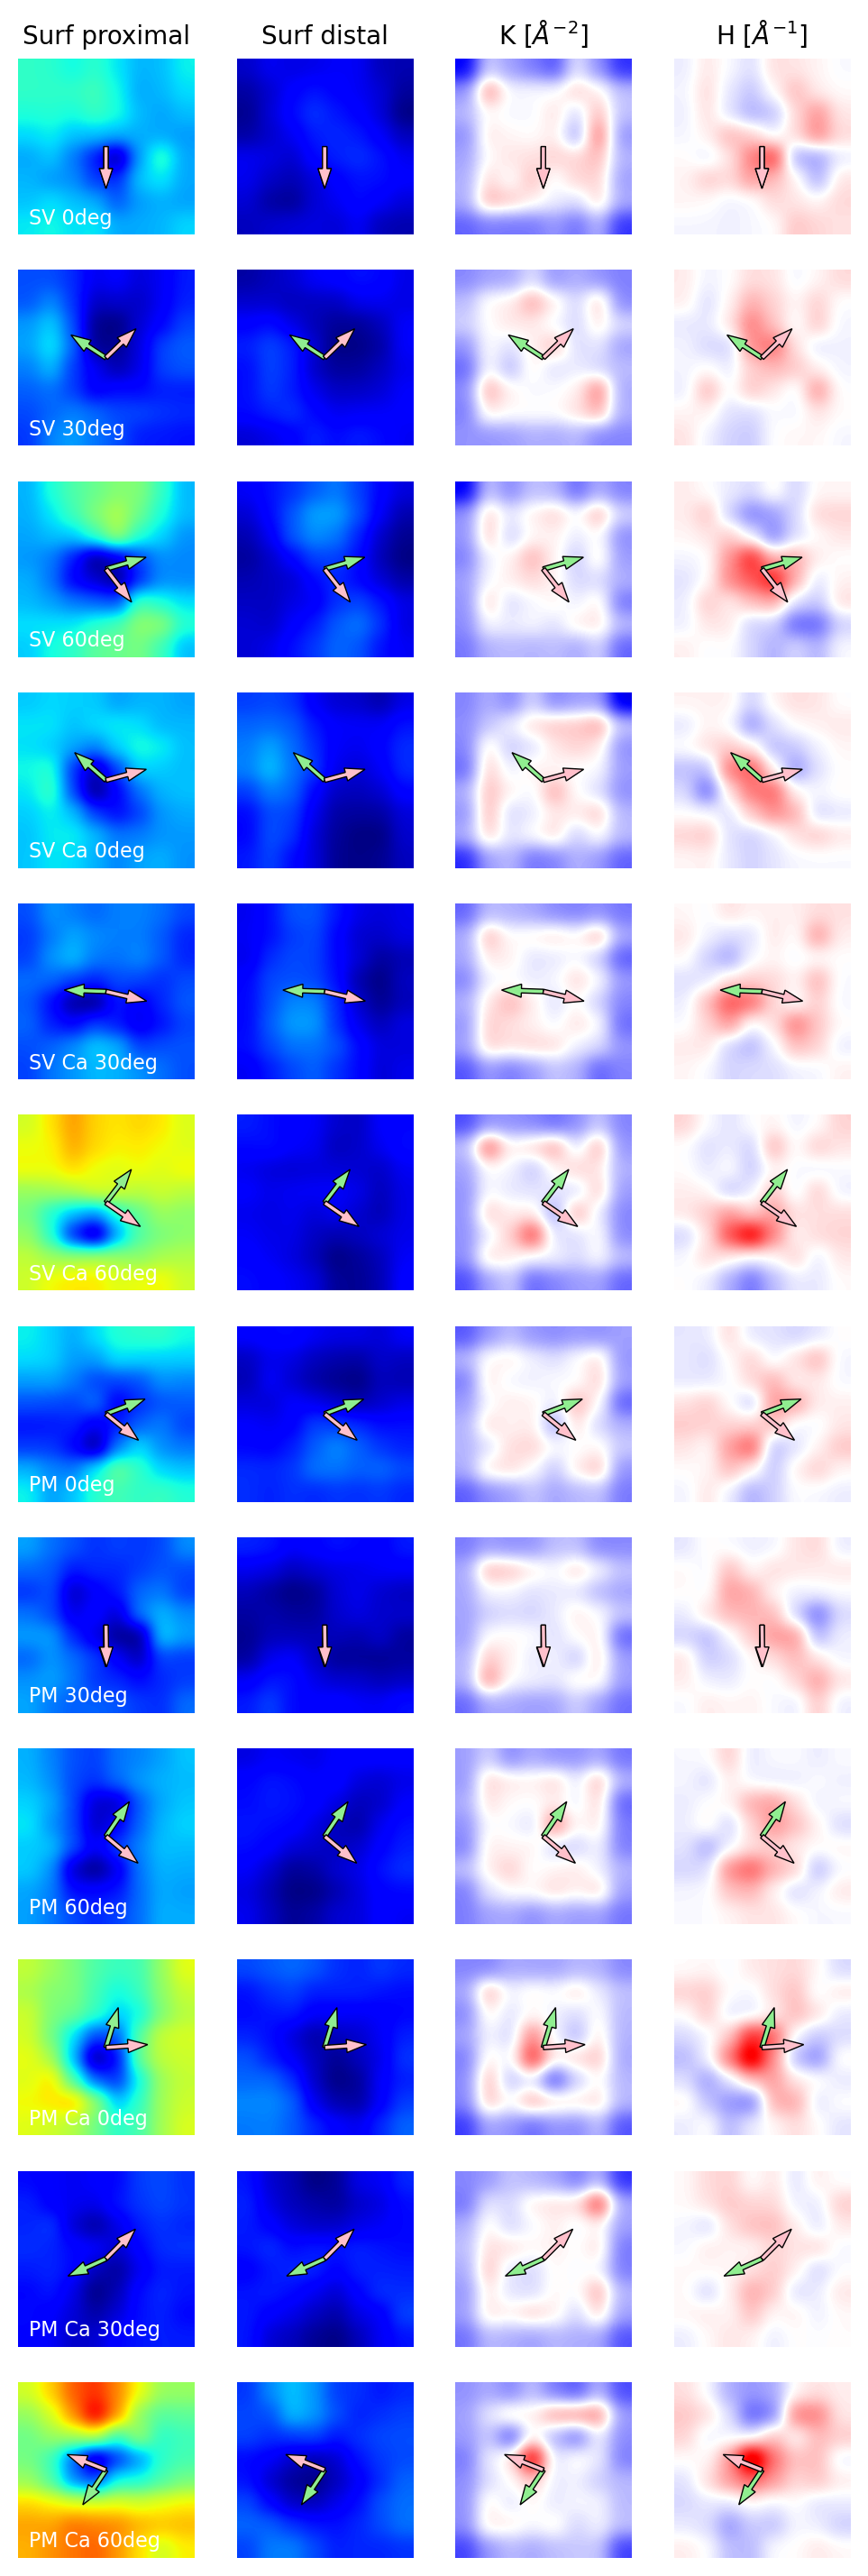

In [7]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax_array = plt.subplots(nrows=len(universes),
                             ncols=4,
                             figsize=(6,1.5*len(universes)),
                             dpi=200,
                             gridspec_kw={'width_ratios': [3, 3, 3, 3]},
                             squeeze=False)

for idx, files in enumerate(universes):

    leaflets = ['Surf proximal', 'Surf distal', r'K [$\AA^{-2}$]', r'H [$\AA^{-1}$]']

    curvatures = [surf_upper[idx]-surf_upper[idx].min(), surf_lower[idx]-surf_lower[idx].min(),
                  gauss_upper[idx], mean_upper[idx]]

    min_val, max_val = np.amin(curvatures), np.amax(curvatures)

    ax1, ax2, ax3, ax4 = ax_array[idx]
    
    for ax, mc, lf in zip((ax1, ax2, ax3, ax4), curvatures, leaflets):

        if 'Surf' in lf:
            im = ax.imshow(mc, interpolation='gaussian', cmap='jet', origin='lower', vmin=0, vmax=6)
        else:
            im = ax.imshow(mc, interpolation='gaussian', cmap='seismic', origin='lower', vmin=-1, vmax=1)

        ax.set_aspect('equal')

        min_angle, max_angle = angles_per_universes[idx]
    
        def plot_angle(angle, color):
            
            arrowlen = 1
            
            #print('Plotting angle for {} {} at {} rad'.format(*files[-2:], angle))
            
            # the ax dimensions are -0.5, 7.5
            ax.arrow(y=3.5,
                     x=3.5,
                     dy=arrowlen*np.cos(angle),
                     dx=arrowlen*np.sin(angle),
                     width=0.2,
                     facecolor=color,
                     linewidth=0.5)
        
        plot_angle(min_angle, 'lightgreen')            
        plot_angle(max_angle, 'pink')
        
        if lf=='Surf proximal':
            ax.text(0,0,'{} {}'.format(*files[-2:]),
                   font = {'size': 8},
                   color='w')
        
        if idx == 0:
            ax.set_title('{}'.format(lf),
                        font={'size': 10})

        ax.axis('off')

    #plt.colorbar(im, cax=ax3)

save_figures(fig, 'figures/c2a_curvature')

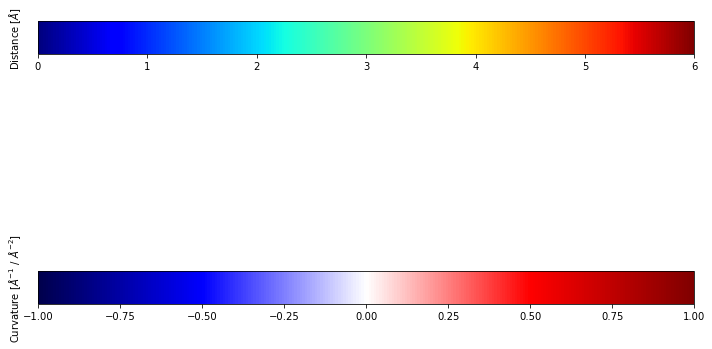

In [8]:
fig, ax_array = plt.subplots(2,
                             figsize=(10, 10),
                             squeeze=True)

a = np.array([[0,6]])
img = plt.imshow(a, cmap="jet")
ax_array[0].set_visible(False)
ax_array[1].set_visible(False)
#cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="horizontal", ax=ax_array[0])
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Distance [$\AA$]')
a = np.array([[-1,1]])
img = plt.imshow(a, cmap="seismic")
#cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="horizontal", ax=ax_array[1])
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Curvature [$\AA^{-1}$ / $\AA^{-2}$]')
plt.tight_layout()

save_figures(fig, 'figures/curvature_cmap')

### For Interpretation of K and H

![alt text](https://www.researchgate.net/profile/Ali_Gholipour/publication/51117804/figure/fig2/AS:394365261369344@1471035413031/Basic-shapes-defined-by-the-signs-of-mean-and-Gaussian-curvatures.png "Geometric implications of K and H")

In [9]:
universes = [
              (('../sv_membrane/membrane_ctrl/parse_traj_900ns_nowater.gro', '../sv_membrane/membrane_ctrl/parse_traj_900ns_nowater.xtc'), 'SV', 'ctrl'),
              (('../pm_membrane/membrane_ctrl/parse_traj_900ns_nowater.gro', '../pm_membrane/membrane_ctrl/parse_traj_900ns_nowater.xtc'), 'PM', 'ctrl'),
            ]


In [10]:
surf_upper = []
surf_lower = []

mean_upper = []
mean_lower = []

gauss_upper = []
gauss_lower = []

for files in universes:
    
    print("Reading files from:\n{}".format(*files[0]))
    u = Universe(*files[0], in_memory=True)
    
    ## Selections
    ag = u.atoms

    # we need the lipid leaflet phosphates for curvature
    # calculation
    selection = '(resname DOPS or resname POPE or resname POPC or resname POPI2 or resname POGL) and name P'
    L = LeafletFinder(u, selection, cutoff=15)
    leaflet0 = L.groups(0)
    leaflet1 = L.groups(1)
    
    # center protein in xy and align leaflet0 with z=20
    transform = center_protein_xy_and_translate_membrane_z(ag, prot,
                                                           leaflet1,
                                                           phosphate_z=20)
    u.trajectory.add_transformations(transform)

    # set the dimensions of the analysis grid to the largest dimensions observed for the
    # box during the trajectory
    leaflet0positions_x = np.array([u.dimensions[0] for _ in u.trajectory])
    x_range = (0, leaflet0positions_x.max())

    leaflet0positions_y = np.array([u.dimensions[1] for _ in u.trajectory])
    y_range = (0, leaflet0positions_y.max())
    
    ## Calculation of curvature
    curvature_upper_leaflet = MembraneCurvature(leaflet0,
                                                select='all',
                                                wrap=True, # wrap=False when passing preprocessed trajs!
                                                n_x_bins=8,
                                                n_y_bins=8,
                                                x_range=x_range,
                                                y_range=y_range).run()

    gauss_upper.append(curvature_upper_leaflet.results.average_gaussian)
    mean_upper.append(curvature_upper_leaflet.results.average_mean)
    surf_upper.append(curvature_upper_leaflet.results.average_z_surface)
    
    curvature_lower_leaflet = MembraneCurvature(leaflet1,
                                            select='all',
                                            wrap=True, # wrap=False when passing preprocessed trajs!
                                            n_x_bins=8,
                                            n_y_bins=8,
                                            x_range=x_range,
                                            y_range=y_range).run()

    gauss_lower.append(curvature_lower_leaflet.results.average_gaussian)
    mean_lower.append(curvature_lower_leaflet.results.average_mean)
    surf_lower.append(curvature_lower_leaflet.results.average_z_surface)

Reading files from:
../sv_membrane/membrane_ctrl/parse_traj_900ns_nowater.gro


MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalysis.analysis.base: INFO     Finishing up


Reading files from:
../pm_membrane/membrane_ctrl/parse_traj_900ns_nowater.gro


MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalysis.analysis.base: INFO     Finishing up


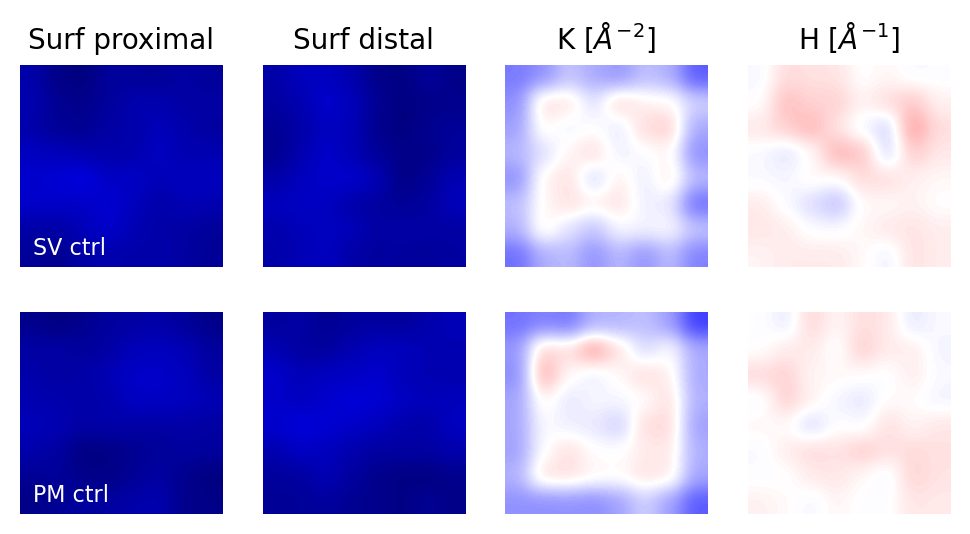

In [11]:
fig, ax_array = plt.subplots(nrows=len(universes),
                             ncols=4,
                             figsize=(6,1.5*len(universes)),
                             dpi=200,
                             gridspec_kw={'width_ratios': [3, 3, 3, 3]},
                             squeeze=False)

for idx, files in enumerate(universes):

    leaflets = ['Surf proximal', 'Surf distal', r'K [$\AA^{-2}$]', r'H [$\AA^{-1}$]']

    curvatures = [surf_upper[idx]-surf_upper[idx].min(), surf_lower[idx]-surf_lower[idx].min(),
                  gauss_upper[idx], mean_upper[idx]]

    min_val, max_val = np.amin(curvatures), np.amax(curvatures)

    ax1, ax2, ax3, ax4 = ax_array[idx]
    
    for ax, mc, lf in zip((ax1, ax2, ax3, ax4), curvatures, leaflets):

        if 'Surf' in lf:
            im = ax.imshow(mc, interpolation='gaussian', cmap='jet', origin='lower', vmin=0, vmax=8)
        else:
            im = ax.imshow(mc, interpolation='gaussian', cmap='seismic', origin='lower', vmin=-1, vmax=1)

        ax.set_aspect('equal')
        
        if lf=='Surf proximal':
            ax.text(0,0,'{} {}'.format(*files[-2:]),
                   font = {'size': 8},
                   color='w')
        
        if idx == 0:
            ax.set_title('{}'.format(lf),
                        font={'size': 10})

        ax.axis('off')

save_figures(fig, 'figures/membranes_ctrl')